<a href="https://colab.research.google.com/github/dvsseed/PyTorch_CNN_MNIST/blob/master/PyTorch_MNIST_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN—PyTorch—MNIST @Date: 2020-08-12
##### *以下示範碼執行所需時間約90秒(GPU)、535秒(CPU)*
---



![Coding Style](https://4.bp.blogspot.com/-0pYHjZbv-48/Wkc5cPmrXDI/AAAAAAAAHkM/H2hnkggGlT83-B81ofzNZygpZNlqBcO9ACLcBGAs/s640/paradigm_shift.jpg)

**CNN--PyTorch Coding Step**:
1. 安裝套件
2. 匯入套件
3. 建立日誌檔
4. 讀取參數序列檔
5. 使用GPU(加速)或CPU
6. 圖片轉換(預處理)
7. 準備資料集(MNIST)：Train(42,000)、Validation(18,000)、Test(10,000)
8. 建立CNN模型(3Conv+3FC)
9. 設定CNN參數(Epochs, Learning Rate, Loss function, Optimizer)
10. 訓練(checkpoint)CNN模型(計算Accuracy, Loss並顯示結果)
11. 預測CNN模型(計算Accuracy, Loss並顯示結果)
12. 評估CNN模型-驗證指標(Validation index): 混淆矩陣(Confusion Matrix)
13. 調參優化
14. 儲存(checkpoint)模型相關數據
15. 讀取(checkpoint)模型相關數據
16. 測試CNN模型(計算Accuracy, Loss並顯示各類別的結果)
17. 讀取日誌

---




# **1. 安裝套件**
[目的] 安裝Google Colab沒有的套件

[*背景知識*] 執行 pip install...請參攷 https://pip.pypa.io/en/stable/installing/ 

In [1]:
!pip install torch_optimizer  # for AdaBound
Checkpoint = 1  # if checkpoint or not

![Packages](https://manalelaidouni.github.io/assets/img/pexels/Pytorch-package-hierarchy.jpg)

---



# **1. 匯入套件**
[目的] 備妥相關執行套件

In [2]:
# Import Libraries
import torch
import torch.nn as nn
# import torch.optim as optim
from torch.optim import lr_scheduler
import torch_optimizer as optim  # for AdaBound
import torch.utils.data as dset
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import time
from datetime import datetime
import os
import itertools
import argparse
import yaml
import sys
import logging
from pytz import timezone
from termcolor import colored

![logging](https://files.realpython.com/media/Python-Logging-A-Stroll-Through-The-Source-Code_Watermarked.efa1d31c4fe4.jpg)

# **3. 建立日誌檔**
[目的] 使用日誌檔留下執行時間、狀態、訊息...等，以利後續維護、Debug

[背景知識] logging — Logging facility for Python, 請參攷 https://docs.python.org/3/library/logging.html


In [3]:
# 建立log記錄檔
def timetz(*args):
  return datetime.now(tz).timetuple()


logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s', datefmt='%Y-%m-%d %H:%M', handlers=[logging.FileHandler('cnn.log', 'w', 'utf-8'), ])
tz = timezone('Asia/Taipei')  # UTC
logging.Formatter.converter = timetz  # 調整時區

# logging.debug('Hello debug!')
# logging.info('Hello info!')
# logging.warning('Hello warning!')
# logging.error('Hello error!')
# logging.critical('Hello critical!')

![YAML](https://blog.codemagic.io/uploads/Codemagic-io_Blog_Yaml-10-tips.2367b7a53ec8bb46bcea06ab69b0d6a4f9c6b075c3b7a33918faa4c470339549.png)

# **4. 讀取參數序列檔**
[目的] 使用YAML Ain't a Markup Language可讀性高，可表達資料序列的格式來儲存環境所需的參數設定值

[背景知識] PyYAML Documentation, 請參攷 https://pyyaml.org/wiki/PyYAMLDocumentation

In [4]:
# 參數資料序列化, write Python data into a YAML file
config_exp = {'BatchSize': 16,  # 批量大小
        'NumClasses': 10,  # 類別
        'Epoch': 3,  # 訓練的迭代次數
        'LearningRate': 0.001,  # Learning rate，反向傳播的學習率
        'PATHcp': './checkpoint.pth',  # checkpoint 暫存檔
        'PATH': './model.pth',  # 模型參數儲存檔
        'Channels': 1,  # MNIST圖片: C
        'Height': 28,  # MNIST圖片: H
        'Width': 28  # MNIST圖片: W
        }

PATHyml = 'cnn_mnist.yaml'
with open(PATHyml, 'w') as f:
  data = yaml.dump(config_exp, f)

In [5]:
# 讀取yaml/yml檔, read a YAML file
with open(PATHyml) as f:
  p = yaml.safe_load(f)
  print(p)

{'BatchSize': 16, 'Channels': 1, 'Epoch': 3, 'Height': 28, 'LearningRate': 0.001, 'NumClasses': 10, 'PATH': './model.pth', 'PATHcp': './checkpoint.pth', 'Width': 28}




---


![PyTorch](https://miro.medium.com/max/864/0*dp6NCTWXmbelZwBd)

In [6]:
model_start = time.time()  # start timer
# 列印版本
print(colored('PyTorch version:', 'blue'), torch.__version__)  # PyTorch version
print(colored('CUDA version:', 'blue'), torch.version.cuda)  # Corresponding CUDA version
print(colored('cuDNN version:', 'blue'), torch.backends.cudnn.version())  # Corresponding cuDNN version

PyTorch version: 1.6.0+cu101
CUDA version: 10.1
cuDNN version: 7603




---


![CUDA](https://upload.wikimedia.org/wikipedia/commons/5/59/CUDA.png)

# **5. 使用GPU(加速)或CPU**
[目的] 利用GPU運算資源來節省模型訓練時間

In [7]:
# How many GPUs are there?
if torch.cuda.is_available(): print(colored('GPUs:', 'blue'), torch.cuda.device_count())

# Which GPU Is The Current GPU?
if torch.cuda.is_available(): print(colored('GPU device:', 'blue'), torch.cuda.current_device())

# Get the name of the current GPU
if torch.cuda.is_available(): print(colored('GPU name:', 'blue'), torch.cuda.get_device_name(torch.cuda.current_device()))

# 確認 GPU 是否可用
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(colored('GPU State:', 'blue'), device)

GPUs: 1
GPU device: 0
GPU name: Tesla T4
GPU State: cuda:0




---


![Image transform](https://www.cse.iitb.ac.in/~vkaushal/talk/auto-augment/featured_huc5f6bfa335655300e966e45366a24701_359424_720x0_resize_lanczos_2.png)

# **6. 圖片轉換(預處理)**
[目的] 處理圖片及轉換格式, 以便數據增強

[背景知識] TORCHVISION.TRANSFORMS, 請參攷 https://pytorch.org/docs/stable/torchvision/transforms.html

In [8]:
# Image Transform
Transform = transforms.Compose(
  [
   transforms.ToTensor(),  # 轉成 Tensor 型態
   transforms.Normalize((0.5,), (0.5,)),  # 正規化
  ]
)



---


![MNIST](https://jason-chen-1992.weebly.com/uploads/1/0/8/5/108557741/example-images-from-the-mnist-dataset_orig.png)

# **7. 準備資料集(MNIST)**：Train(42,000)、Validation(18,000)、Test(10,000)
[目的] 規劃訓練、驗證、測試所需的資料集, 並依照batch size打包, 以完成圖像及標籤資料的讀取

[背景知識] TORCHVISION.DATASETS, 請參攷 https://pytorch.org/docs/stable/torchvision/datasets.html

In [9]:
# Dataset
BatchSize = p['BatchSize']

TrainSet0 = datasets.MNIST(root='MNIST', download=True, train=True, transform=Transform)
TestSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=Transform)

# 切分70%為訓練集、30%為驗證集
train_size = int(0.7 * len(TrainSet0))
valid_size = len(TrainSet0) - train_size
TrainSet, ValidSet = torch.utils.data.random_split(TrainSet0, [train_size, valid_size])

TrainLoader = dset.DataLoader(TrainSet, batch_size=BatchSize, shuffle=True)  # 打亂數據則將shuffle=True
ValidLoader = dset.DataLoader(ValidSet, batch_size=BatchSize, shuffle=True)
# 測試集
TestLoader = dset.DataLoader(TestSet, batch_size=BatchSize, shuffle=False)
Test10kLoader = dset.DataLoader(TestSet, batch_size=len(TestSet), shuffle=False)



---


![CNN](https://jason-chen-1992.weebly.com/uploads/1/0/8/5/108557741/dnn-for-mnist_1_orig.png)

# **8. 建立CNN模型**(3Conv+3FC)
[目的] 設計神經網路模型(基於autograd), 定義網路各層維度及結構

[背景知識] MODULE, 請參攷 https://pytorch.org/docs/stable/generated/torch.nn.Module.html

In [10]:
# Define model
class CNNModelClass(nn.Module):  # 使用 torch.nn 來建構神經網路
  def __init__(self, NumClasses):
    super(CNNModelClass, self).__init__()
    # Convolution 1, input_shape=(1,28,28)
    self.features = nn.Sequential(
      nn.Conv2d(in_channels=1,  # input height
           out_channels=32,  # n_filters
           kernel_size=3,   # filter size
           stride=1,     # filter movement/step
           padding=1     # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
      ),
      nn.BatchNorm2d(num_features=32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # output_shape=(32,14,14)
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # input_shape=(32,14,14)
      nn.BatchNorm2d(num_features=64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # output_shape=(64,7,7)
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # input_shape=(64,7,7)
      nn.BatchNorm2d(num_features=128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # output_shape=(128,4,4)
    )
    self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
    self.drop_out = nn.Dropout2d(p=0.5)
    self.fc_drop = nn.Dropout2d(p=0.5)
    self.fc = nn.Sequential(
      nn.Linear(in_features=128 * 4 * 4, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=NumClasses)
    )


  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = x.view(-1, 128 * 4 * 4)
    # x = self.drop_out(x)
    x = self.fc(x)
    # x = self.fc_drop(x)
    return x


  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


NumClasses = p['NumClasses']
# Initialize model
model = CNNModelClass(NumClasses).to(device)
print(model)  # 列印結構

CNNModelClass(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (drop_out): Dropout2d(p=0.5, inplace=False)
  (fc_drop): Dropout2d(p=0.5, inplace=False)
  (fc): Sequential



---


**Dimension Calculations**

* $O=\frac{W−K+2\times P}{S}+1$
> * O: output height/length
> * W: input height/length
> * K: filter size(kernel size)
> * P: padding, $P=\frac{K−1}{2}$
> * S: stride

![Model](https://www.deeplearningwizard.com/deep_learning/practical_pytorch/images/cnn10-2n.png)

In [11]:
# 查看模型每層輸出細節, MNIST=(C,H,W)=(1,28,28)
Channels = p['Channels']
Height = p['Height']
Width = p['Width']
summary(model, input_size=(Channels, Height, Width), batch_size=BatchSize)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 32, 28, 28]             320
       BatchNorm2d-2           [16, 32, 28, 28]              64
              ReLU-3           [16, 32, 28, 28]               0
         MaxPool2d-4           [16, 32, 14, 14]               0
            Conv2d-5           [16, 64, 14, 14]          18,496
       BatchNorm2d-6           [16, 64, 14, 14]             128
              ReLU-7           [16, 64, 14, 14]               0
         MaxPool2d-8             [16, 64, 7, 7]               0
            Conv2d-9            [16, 128, 7, 7]          73,856
      BatchNorm2d-10            [16, 128, 7, 7]             256
             ReLU-11            [16, 128, 7, 7]               0
        MaxPool2d-12            [16, 128, 3, 3]               0
AdaptiveAvgPool2d-13            [16, 128, 4, 4]               0
           Linear-14                  [

In [12]:
# Counting number parameters in a CNN model
def count_model_layers(model):
  conv = 0
  fc = 0
  for layer in model.modules():
    if isinstance(layer, nn.Conv2d):
      conv += 1
    elif isinstance(layer, nn.Linear):
      fc += 1

  return conv, fc


num_parameters = sum(torch.numel(parameter) for parameter in model.parameters())
print(colored('Model Params: ', 'blue') + '%.2f M' % (num_parameters / 1e6))
print(colored('Model: Convolutional layer: ', 'blue') + '%s, Fully connected layer: %s' % count_model_layers(model))

params = list(model.parameters())
print(len(params))  # 列印層數

# for name, parameters in model.named_parameters():
  # print(name, ':', parameters.size())

Model Params: 1.41 M
Model: Convolutional layer: 3, Fully connected layer: 3
18




---


![AdaBound](https://camo.githubusercontent.com/6e32dcc3e881e2c28786f8b628dcfa2b8d27317f/68747470733a2f2f7777772e6c756f6c632e636f6d2f6173736574732f72657365617263682f616461626f756e642f616461626f756e642d62616e6e65722e706e67)

# **9. 設定CNN參數**(Epoch, Learning Rate, Loss function, Optimizer)
[目的] 設定CNN相關參數, 以供模型所需

[背景知識] optim.AdaBound, 請參攷 https://creme-ml.github.io/api-reference/optim/AdaBound/

In [13]:
# Parameters
Epoch = p['Epoch']  # 訓練的迭代次數
LearningRate = p['LearningRate']  # Learning rate，反向傳播的學習率
Criterion = nn.CrossEntropyLoss()  # 損失函數(Loss function)

# Initialize optimizer
# Optimizer = optim.Adam(model.parameters(), lr=LearningRate)  # 優化器optimize all cnn parameters
Optimizer = optim.AdaBound(model.parameters(), lr=LearningRate, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3, eps=1e-8, weight_decay=0, amsbound=False)

# change learning rate schedule
Scheduler = lr_scheduler.StepLR(Optimizer, 10, 0.1)  # for each 10 epoch, learning rate x 0.1

In [14]:
# Print model's state_dict
print(colored('Model\'s state_dict:', 'blue'))
for param_tensor in model.state_dict():
  print(param_tensor, '\t', model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print(colored('Optimizer\'s state_dict:', 'blue'))
for var_name in Optimizer.state_dict():
  print(var_name, '\t', Optimizer.state_dict()[var_name])

Model's state_dict:
features.0.weight 	 torch.Size([32, 1, 3, 3])
features.0.bias 	 torch.Size([32])
features.1.weight 	 torch.Size([32])
features.1.bias 	 torch.Size([32])
features.1.running_mean 	 torch.Size([32])
features.1.running_var 	 torch.Size([32])
features.1.num_batches_tracked 	 torch.Size([])
features.4.weight 	 torch.Size([64, 32, 3, 3])
features.4.bias 	 torch.Size([64])
features.5.weight 	 torch.Size([64])
features.5.bias 	 torch.Size([64])
features.5.running_mean 	 torch.Size([64])
features.5.running_var 	 torch.Size([64])
features.5.num_batches_tracked 	 torch.Size([])
features.8.weight 	 torch.Size([128, 64, 3, 3])
features.8.bias 	 torch.Size([128])
features.9.weight 	 torch.Size([128])
features.9.bias 	 torch.Size([128])
features.9.running_mean 	 torch.Size([128])
features.9.running_var 	 torch.Size([128])
features.9.num_batches_tracked 	 torch.Size([])
fc.0.weight 	 torch.Size([512, 2048])
fc.0.bias 	 torch.Size([512])
fc.2.weight 	 torch.Size([512, 512])
fc.2.bias



---


![Training](https://2.bp.blogspot.com/-lo4ANmafiQM/WVpEeo68VPI/AAAAAAAAWxE/7FJBUGp-GrQFL5fUYEg6tQAJWXUHrtgWgCLcBGAs/s1600/3812_1.png)

# **10. 訓練**(checkpoint)**CNN模型**(計算Accuracy, Loss並顯示結果)
# **11. 預測CNN模型**(計算Accuracy, Loss並顯示結果)

In [15]:
# Train、Validation
def training_net(Epoch, trainLoader, Criterion, Optimizer, PATHcp):
  if start_epoch == 0:
    training_loss = []
    validing_loss = []
    training_accuracy = []
    validing_accuracy = []
  else:
    checkpoint = torch.load(PATHcp, map_location='cpu')
    training_loss = checkpoint['training_loss']
    validing_loss = checkpoint['validing_loss']
    training_accuracy = checkpoint['training_accuracy']
    validing_accuracy = checkpoint['validing_accuracy']

  for epoch in range(start_epoch, Epoch):
    Scheduler.step()
    train_start = time.time()
    train_losss = 0.0
    t_loss = 0.0
    train_correct = 0
    train_total = 0
    model.train()
    for times, tdata in enumerate(TrainLoader):
      tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)

      # 反向傳播(Backward propagation), 計算loss function更新模型的權重
      # Zero the parameter gradients, 將參數、梯度緩衝區歸零
      Optimizer.zero_grad()

      # Foward + backward + optimize
      toutputs = model(tinputs)
      _, predicted = torch.max(toutputs.data, 1)
      train_total += tlabels.size(0)
      train_correct += (predicted == tlabels).sum().item()

      train_loss = Criterion(toutputs, tlabels)
      train_loss.backward()
      train_accuracy = 100 * train_correct / float(train_total)
      train_losss += train_loss.item()
      t_loss = train_losss / (float(train_total) / BatchSize)

      Optimizer.step()

    training_accuracy.append(train_accuracy)
    training_loss.append(t_loss)
    # Print statistics
    print(colored('Epoch: ', 'magenta') + '[%d/%d, %d/%d] - <Train>, loss: %.6f, accuracy: %.4f %%, duration: %.4f sec' % (
        (epoch + 1),
        Epoch,
        (times + 1),
        len(TrainLoader),
        t_loss,
        train_accuracy,
        (time.time() - train_start))
    )

    valid_start = time.time()
    valid_losss = 0.0
    v_loss = 0.0
    valid_correct = 0
    valid_total = 0
    model.eval()
    for times, vdata in enumerate(ValidLoader):
      vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
      voutputs = model(vinputs)
      _, predicted = torch.max(voutputs.data, 1)
      valid_total += vlabels.size(0)
      valid_correct += (predicted == vlabels).sum().item()
      valid_loss = Criterion(voutputs, vlabels)
      valid_accuracy = 100 * valid_correct / float(valid_total)
      valid_losss += valid_loss.item()
      v_loss = valid_losss / (float(valid_total) / BatchSize)

    validing_accuracy.append(valid_accuracy)
    validing_loss.append(v_loss)
    # Print statistics
    print(colored('Epoch: ', 'blue') + '[%d/%d, %d/%d] - <Validation>, loss: %.6f, accuracy: %.4f %%, duration: %.4f sec' % (
        (epoch + 1),
        Epoch,
        (times + 1),
        len(ValidLoader),
        v_loss,
        valid_accuracy,
        (time.time() - valid_start))
    )

    # Checkpoint
    # print('Checkpoint ...')
    torch.save({'optimizer_state_dict': Optimizer.state_dict(),
          'model_state_dict': model.state_dict(),
          'epoch': epoch + 1,
          'training_loss': training_loss,
          'validing_loss': validing_loss,
          'training_accuracy': training_accuracy,
          'validing_accuracy': validing_accuracy}, PATHcp)

  return training_loss, training_accuracy, validing_loss, validing_accuracy


# Checkpoint
PATHcp = p['PATHcp']
if Checkpoint:
  if os.path.exists(PATHcp):
    os.remove(PATHcp)

if os.path.exists(PATHcp):
  print(colored('Restart from checkpoint {}'.format(PATHcp), 'blue'))
  checkpoint = torch.load(PATHcp, map_location='cpu')
  Optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  model.load_state_dict(checkpoint['model_state_dict'])
  if torch.cuda.is_available():
    model.cuda()
  else:
    model = model.cpu()

  start_epoch = checkpoint['epoch']
  training_loss = checkpoint['training_loss']
  validing_loss = checkpoint['validing_loss']
  training_accuracy = checkpoint['training_accuracy']
  validing_accuracy = checkpoint['validing_accuracy']
else:
  print(colored('No checkpoint file at {}'.format(PATHcp), 'blue'))
  start_epoch = 0
  if torch.cuda.is_available():
    model = model.cuda()
  else:
    model = model.cpu()

print('Started Training.')
training_loss, training_accuracy, validing_loss, validing_accuracy = training_net(Epoch, TrainLoader, Criterion, Optimizer, PATHcp)
print('Finished Training.')
logging.info('>>Training done!')

No checkpoint file at ./checkpoint.pth
Started Training.


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch_optimizer/adabound.py:142: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch: [1/3, 2625/2625] - <Train>, loss: 0.145279, accuracy: 95.4833 %, duration: 20.5135 sec
Epoch: [1/3, 1125/1125] - <Validation>, loss: 0.063836, accuracy: 98.1111 %, duration: 3.7002 sec
Epoch: [2/3, 2625/2625] - <Train>, loss: 0.047007, accuracy: 98.6310 %, duration: 20.0044 sec
Epoch: [2/3, 1125/1125] - <Validation>, loss: 0.055989, accuracy: 98.4278 %, duration: 3.6768 sec
Epoch: [3/3, 2625/2625] - <Train>, loss: 0.030146, accuracy: 99.1000 %, duration: 20.2976 sec
Epoch: [3/3, 1125/1125] - <Validation>, loss: 0.044152, accuracy: 98.7056 %, duration: 3.6958 sec
Finished Training.


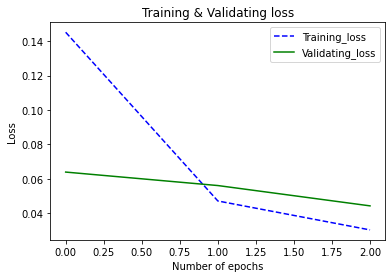

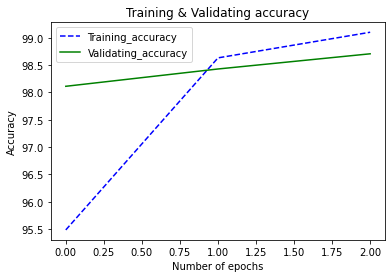

In [16]:
# 訓練、預測結果視覺化(visualization)
plt.plot(range(Epoch), training_loss, 'b--', label='Training_loss')
plt.plot(range(Epoch), validing_loss, 'g-', label='Validating_loss')
plt.title('Training & Validating loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(Epoch), training_accuracy, 'b--', label='Training_accuracy')
plt.plot(range(Epoch), validing_accuracy, 'g-', label='Validating_accuracy')
plt.title('Training & Validating accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



---


![Confusion Matrix](https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg)
![F1 Score](https://4.bp.blogspot.com/-0CJRaFYOJZE/XMfpAkCCKRI/AAAAAAAAEjk/5q7y2hIULvsz62QApm7DOAXuc2u02Sn5wCEwYBhgL/s400/f%2Bscore.jpg)

# **12. 評估CNN模型**-驗證指標(Validation index): 混淆矩陣(Confusion Matrix)
[背景知識] Confusion Matrix in Machine Learning, 請參攷 https://www.geeksforgeeks.org/confusion-matrix-machine-learning/

Started Evaluating.
Precision: [0.984375   0.98671913 0.99127114 0.9831756  0.98924124 0.98716384
 0.99655765 0.99300325 0.9811321  0.9775991 ]
Recall: [0.99661016 0.9965226  0.9789871  0.9936238  0.99092454 0.9847561
 0.9774901  0.9772246  0.9875371  0.986095  ]
F1 Score: [0.9904548  0.99159664 0.9850908  0.9883721  0.9900822  0.98595846
 0.9869318  0.98505074 0.98432416 0.9818287 ]
Mean: 0.986969
Normalized Confusion Matrix


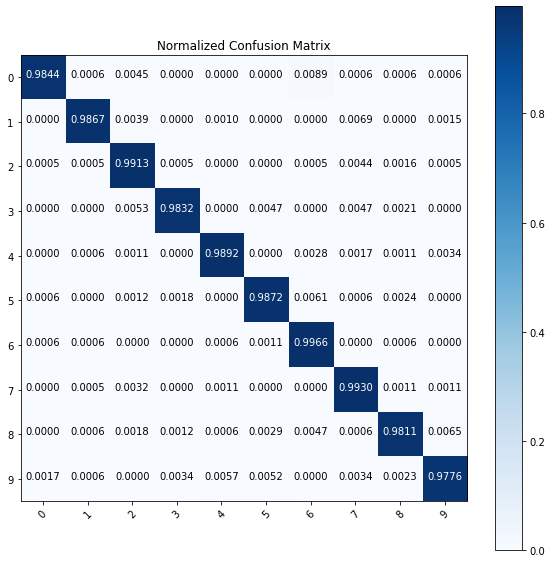

Finished Evaluating.


In [17]:
# 混淆矩陣(Confusion Matrix)
class_names = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
  print(colored(title, 'blue'))
  # print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.4f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i,
        format(cm[i, j], fmt),
        horizontalalignment='center',
        color='white' if cm[i, j] > thresh else 'black')


def evaluate(ValidLoader):
  confusion_matrix = torch.zeros(NumClasses, NumClasses)
  with torch.no_grad():
    model.eval()
    for inputs, labels in ValidLoader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs) 
      _, predicted = torch.max(outputs, 1)
      for true, pred in zip(labels.view(-1), predicted.view(-1)):
        confusion_matrix[true.long(), pred.long()] += 1

  # print('Confusion Matrix:\n{}'.format(confusion_matrix.data.numpy()))
  precision = confusion_matrix.diag() / confusion_matrix.sum(1)
  print(colored('Precision: ', 'blue') + '{}'.format(precision.data.numpy()))
  recall = confusion_matrix.diag() / confusion_matrix.sum(0)
  print(colored('Recall: ', 'blue') + '{}'.format(recall.data.numpy()))
  f1 = 2 * (precision * recall) / (precision + recall)
  print(colored('F1 Score: ', 'blue') + '{}'.format(f1.data.numpy()))
  mean = f1.mean()
  print(colored('Mean: ', 'blue') + '{:.6f}'.format(mean))

  # Plot normalized confusion matrix
  plt.figure(figsize=(10, 10))
  plot_confusion_matrix(confusion_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
  plt.show()


print('Started Evaluating.')
evaluate(ValidLoader)
print('Finished Evaluating.')
logging.info('>>Evaluating done!')

# **13. 調參優化**
[背景知識] 可參攷 https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf
![調參](http://5b0988e595225.cdn.sohucs.com/images/20190221/c429f93326dd4e0bb47ad2806d10660d.jpeg)

# **14. 儲存**(checkpoint)**模型**相關數據
[背景知識] SAVING AND LOADING MODELS, 請參攷 https://pytorch.org/tutorials/beginner/saving_loading_models.html

---



In [18]:
# Saving a General Checkpoint for Inference and/or Resuming Training
# Save final model
PATH = p['PATH']
torch.save({'epoch': Epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': Optimizer.state_dict(),
      'loss': Criterion,
      'training_loss': training_loss,
      'validing_loss': validing_loss,
      'training_accuracy': training_accuracy,
      'validing_accuracy': validing_accuracy}, PATH)

# **15. 讀取**(checkpoint)**模型**相關數據

In [19]:
# Loading a General Checkpoint for Inference and/or Resuming Training
model = CNNModelClass(NumClasses).to(device)
# optimizer = TheOptimizerClass(*args, **kwargs)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
Optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
Epoch = checkpoint['epoch']
Criterion = checkpoint['loss']



---


![Test](https://research.binus.ac.id/airnd/wp-content/uploads/sites/12/2018/03/ConvNet-1-768x346.png)


# **16. 測試CNN模型**(計算Accuracy, Loss並顯示各類別的結果)

In [20]:
# Test
def testing_net(TestLoader):
  test_start = time.time()
  test_losss = 0.0
  t_loss = 0.0
  test_correct = 0
  test_total = 0

  model.eval()  # 模型評估模式，沒有要繼續訓練模型、而只拿來應用

  with torch.no_grad():
    for data in TestLoader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      test_loss = Criterion(outputs, labels)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()
      test_accuracy = 100 * test_correct / float(test_total)
      test_losss += test_loss.item()
      t_loss = test_losss / (float(test_total) / BatchSize)

    print('Accuracy of the network on the 10000 test images: %.4f %%, loss: %.4f, duration: %.4f sec' % (
        test_accuracy,
        t_loss,
        (time.time() - test_start)
        )
    )


print('Started Testing.')
testing_net(TestLoader)
print('Finished Testing.')
logging.info('>>Testing done!')

class_correct = [0 for i in range(p['NumClasses'])]
class_total = [0 for i in range(p['NumClasses'])]

with torch.no_grad():
  model.eval()  # 模型評估模式
  for data in TestLoader:
    inputs, labels = data[0].to(device), data[1].to(device)

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).squeeze()
    for i in range(10):
      label = labels[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
      # print(class_correct)
      # print(class_total)

# 列印10個類別的Accuracy
for i in range(len(class_total)):
  print(colored('Accuracy ', 'blue') + 'of class[%d]: %3f' % (i, (class_correct[i] / class_total[i])))

Started Testing.
Accuracy of the network on the 10000 test images: 99.1400 %, loss: 0.0267, duration: 2.0727 sec
Finished Testing.
Accuracy of class[0]: 0.987034
Accuracy of class[1]: 0.994358
Accuracy of class[2]: 0.995399
Accuracy of class[3]: 0.992013
Accuracy of class[4]: 0.993721
Accuracy of class[5]: 0.985130
Accuracy of class[6]: 0.993197
Accuracy of class[7]: 0.991909
Accuracy of class[8]: 0.990244
Accuracy of class[9]: 0.983077


In [21]:
# 只測試一張圖片
correct = 0
total = 0
num = 1000  # 第1000張圖片

model.eval()  # 模型評估模式，沒有要繼續訓練模型、而只拿來應用

with torch.no_grad():
  for data in Test10kLoader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs[num].view((-1 ,p['Channels'], p['Height'], p['Width']), -1)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += 1
    correct += (predicted == labels[num]).sum().item()
    break

print('Accuracy of the network on the #%d test image: %f %% -> [predict: %d, label: %d]' % (
    num,
    (100 * correct / total),
    predicted,
    labels[num]
    )
)

Accuracy of the network on the #1000 test image: 100.000000 % -> [predict: 9, label: 9]


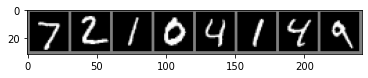

GroundTruth:   7  2  1  0  4  1  4  9


In [22]:
# Test the network on the test data
# functions to show an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()


dataiter = iter(TestLoader)
images, labels = dataiter.next()

# print images
imshow(utils.make_grid(images[:8]))
print(colored('GroundTruth:', 'blue'), ''.join('%3s' % class_names[labels[j]] for j in range(8)))

In [23]:
# Elapsed time
print('The elapsed time(ET) of this CNN model: [%.4f sec]' % (time.time() - model_start))
logging.info('>>ET: [%.4f sec]' % (time.time() - model_start))

The elapsed time(ET) of this CNN model: [88.2169 sec]


# **17. 讀取日誌**


In [24]:
!cat cnn.log

2020-08-12 16:54 INFO >>Training done!
2020-08-12 16:54 INFO >>Evaluating done!
2020-08-12 16:54 INFO >>Testing done!
2020-08-12 16:54 INFO >>ET: [88.2170 sec]
